In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms


import utils
import random
import numpy as np
from tqdm import tqdm

teacher = torchvision.models.vit_b_16(pretrained = True)
student = torchvision.models.vit_b_16(pretrained = True)
# model = torchvision.models.vit_l_32(pretrained=True)

print(f"patch_size : {student.patch_size}")
print(f"image_size : {student.image_size}")
print(f"hidden_dim : {student.hidden_dim}")

use_trained_model = True

normalize = transforms.Normalize(mean=[0.5074,0.4867,0.4411],
                                 std=[0.2011,0.1987,0.2025])

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
])

transform_train = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
])

dataset_val = torchvision.datasets.MNIST(root="./", train=False, transform=transform, download=True)
dataset_train = torchvision.datasets.MNIST(root="./", train=True, transform=transform_train, download=True)

val_loader = torch.utils.data.DataLoader(dataset_val,
                                          batch_size=128,
                                          shuffle=True,
                                          num_workers=4)

train_loader = torch.utils.data.DataLoader(dataset_train,
                                          batch_size=128,
                                          shuffle=True,
                                          num_workers=4)

device = 'cuda' if torch.cuda.is_available() else 'cpu'


patch_size : 16
image_size : 224
hidden_dim : 768


In [3]:
if use_trained_model:
#     teacher = torch.load("CIFAR100_vit_b_16_71.pth")
    pass
else:
    teacher = utils.VisionTransformer(teacher)
    teacher.heads.head = nn.Linear(768, 10)
                         
student = utils.VisionTransformer(student)
student.heads.head = nn.Linear(768, 10)



S_optimizer = optim.SGD(student.parameters(), lr=0.01, momentum=0.9)
T_optimizer = optim.SGD(teacher.parameters(), lr=0.01, momentum=0.9)
CE_loss = nn.CrossEntropyLoss()

S_scheduler = torch.optim.lr_scheduler.MultiStepLR(S_optimizer, milestones=[1,2,3,4,5,6,7], gamma=0.1)
T_scheduler = torch.optim.lr_scheduler.MultiStepLR(T_optimizer, milestones=[1,2,3,4,5,6,7], gamma=0.1)

student = student.cuda()
teacher = teacher.cuda()



In [4]:
if not use_trained_model:
    best_acc = 0.0
    stack = 0  

    criterion_onlylabel = lambda a,b : mse(a*b, b)

    criterion_CE = nn.CrossEntropyLoss()
    mse = nn.MSELoss()
    softmax = torch.nn.Softmax(dim = 1)
    criterion_KLD = torch.nn.KLDivLoss(reduction="batchmean")
    criterion_response = lambda a,b : criterion_KLD(torch.log_softmax(a, dim=1),torch.softmax(b, dim=1))




    torch.manual_seed(0)
    torch.cuda.manual_seed(0)
    torch.cuda.manual_seed_all(0)
    np.random.seed(0)
    cudnn.benchmark = False
    cudnn.deterministic = True
    random.seed(0)


    for epoch in range(100):
        print(f"lr : {T_scheduler.get_last_lr()}")
        T_correct = 0
        S_correct = 0
        all_data = 0

        loss_distill = []
        loss_CE = []
        loss_response = []
        student = student.train()
        for img, label in tqdm(train_loader):
            img = img.cuda()
            label = label.cuda()

            T_optimizer.zero_grad()
            output, _ = teacher(img, 0)

            output = softmax(output)
            loss = criterion_CE(output, label)
            loss.backward()
            T_optimizer.step()
        
        test_acc = utils.test(teacher, val_loader, epoch)
        if test_acc > best_acc:
            stack = 0
            best_acc = test_acc
        else:
            stack+=1
            

        if stack > 5:
            T_scheduler.step()
            stack = 0
    torch.save(teacher, "MNIST_Teacher_9924.pth")
    
    
else:
    teacher = torch.load("MNIST_Teacher_9924.pth")
    
test_acc = utils.test(teacher, val_loader)

100%|██████████| 79/79 [00:15<00:00,  4.94it/s]

0 	 test acc : 0.9924999475479126


In [5]:
teacher = utils.VisionTransformer(teacher)
teacher = teacher.cuda()

In [20]:
for img, label in tqdm(train_loader):
    img = img.cuda()
    break

  0%|          | 0/469 [00:00<?, ?it/s]


In [21]:
for i in range(100):
    output, feature = teacher(img, 0)
    break
    print(feature.shape)

In [22]:
from matplotlib import pyplot as plt

output, feature = teacher(img, 0)
feature = torch.mean(feature, dim = 1)

img = img - torch.min(img)
img = img / torch.max(img) * 255
img = torch.tensor(img, dtype = int)

/tmp/ipykernel_4105433/3208187288.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img, dtype = int)


In [23]:
import torch.nn.functional as nnf
size = img[0][0].shape
size

torch.Size([224, 224])

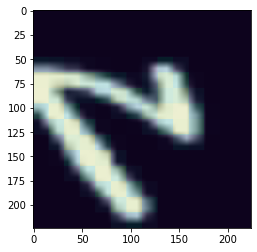

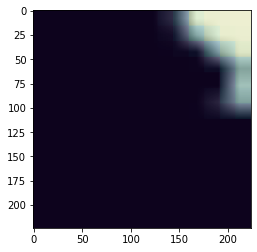

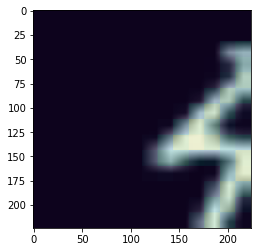

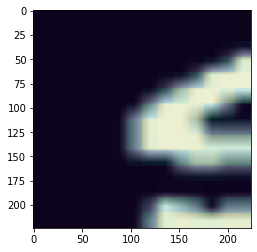

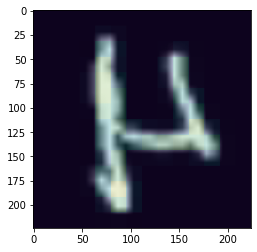

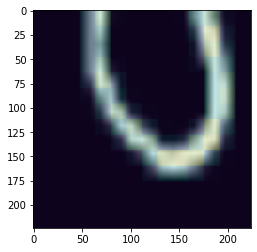

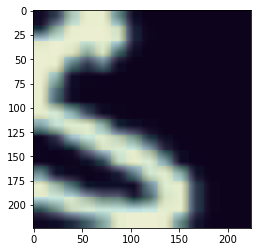

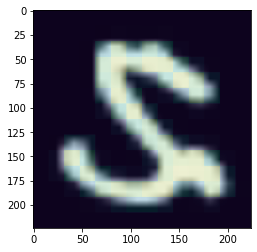

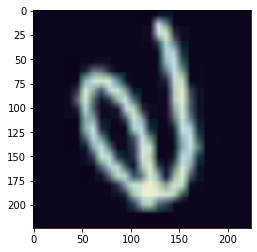

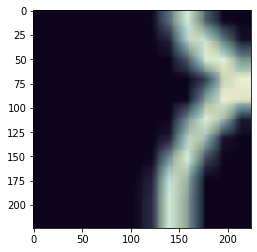

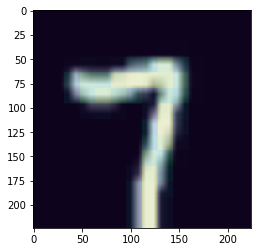

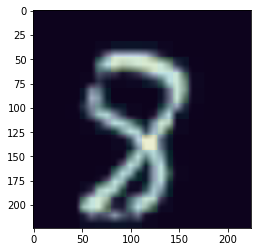

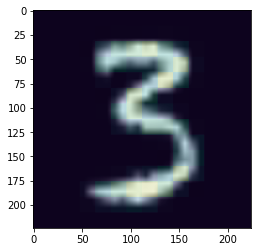

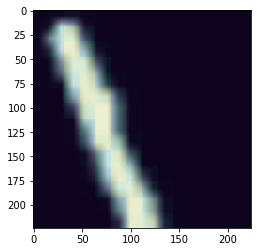

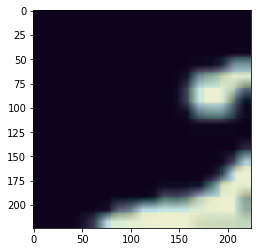

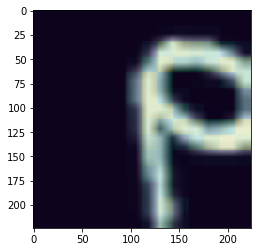

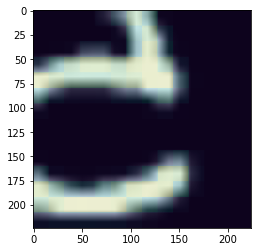

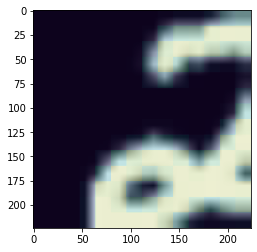

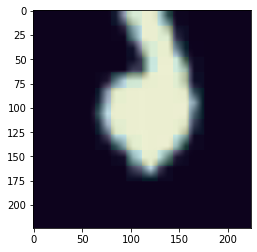

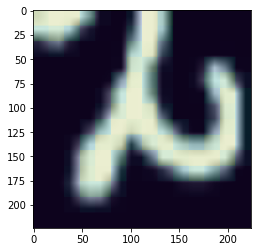

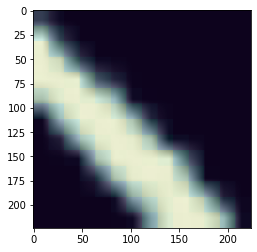

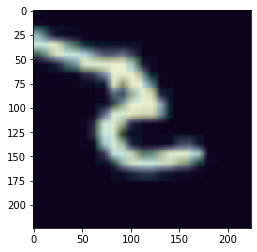

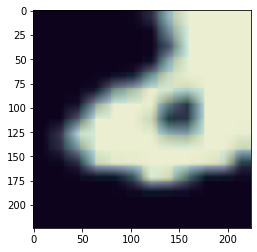

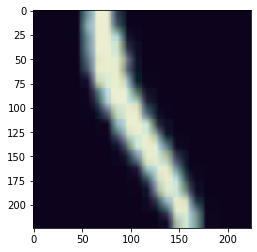

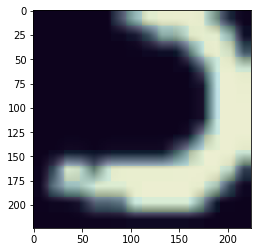

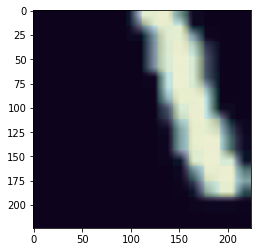

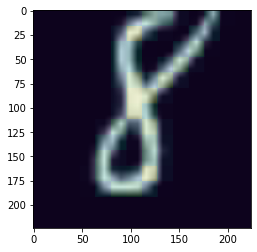

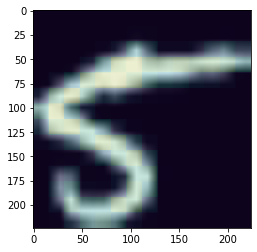

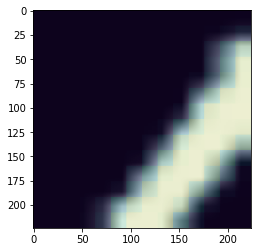

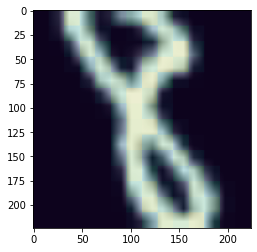

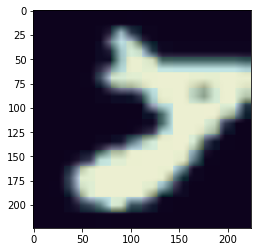

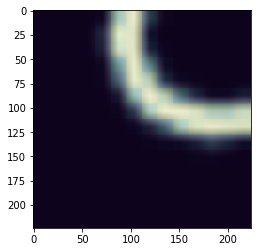

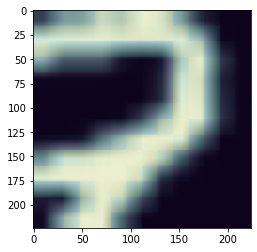

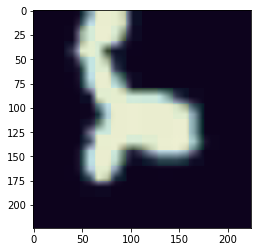

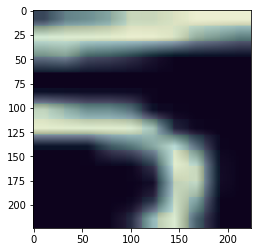

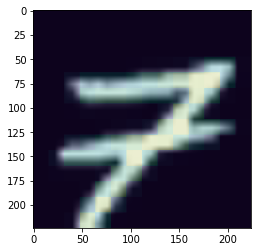

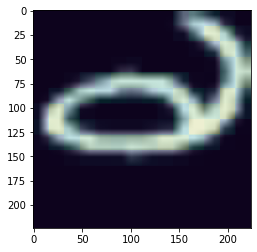

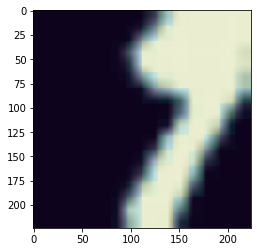

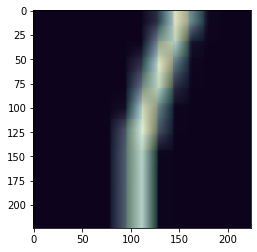

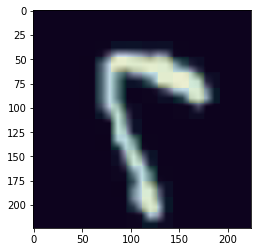

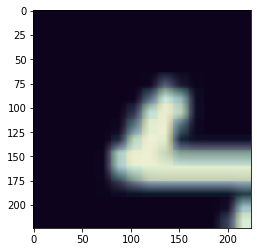

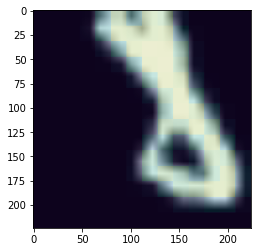

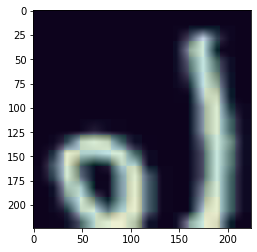

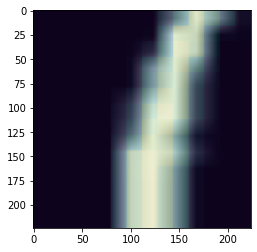

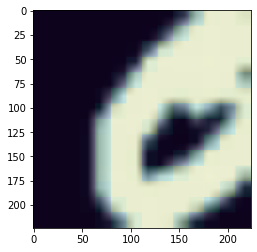

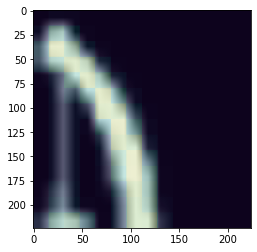

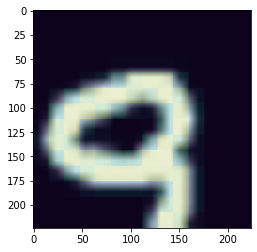

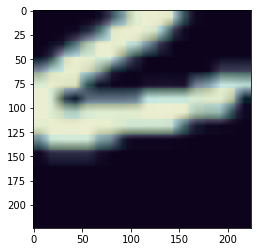

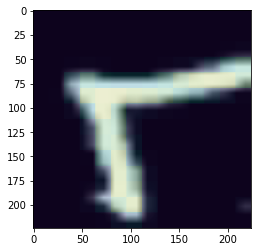

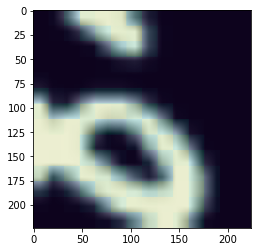

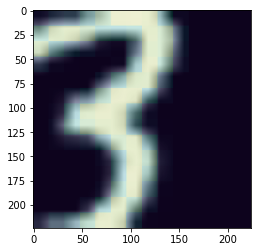

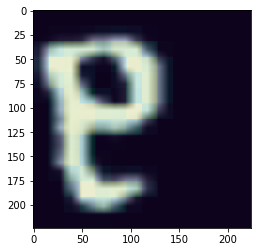

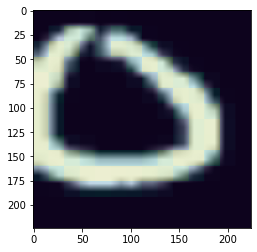

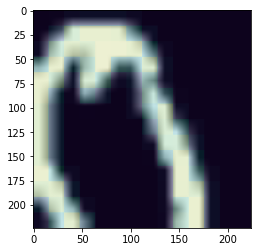

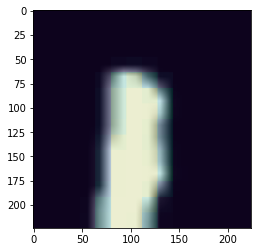

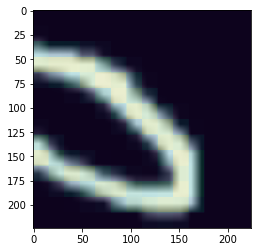

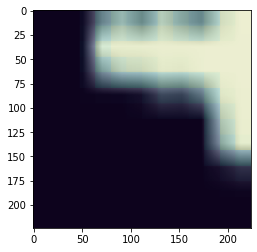

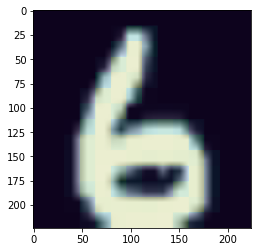

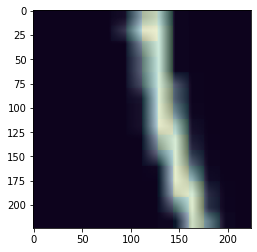

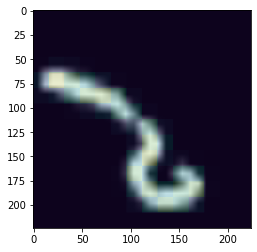

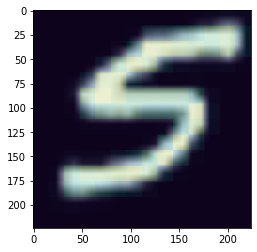

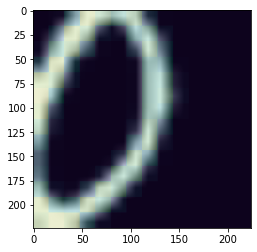

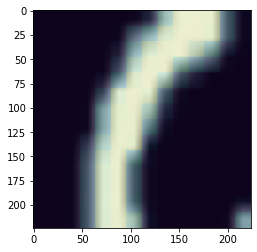

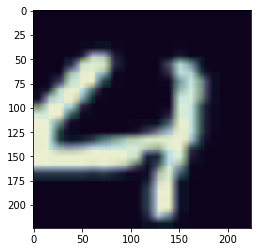

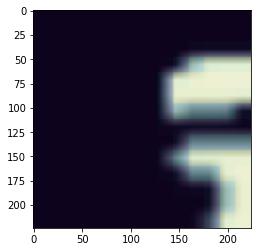

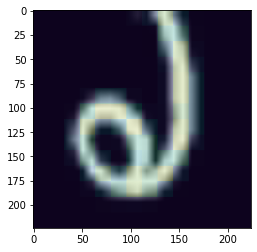

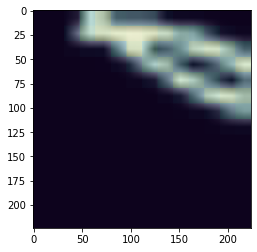

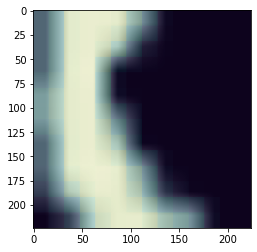

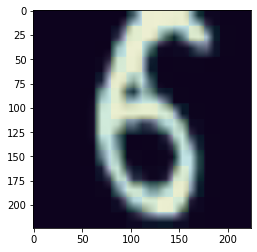

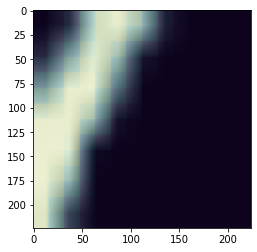

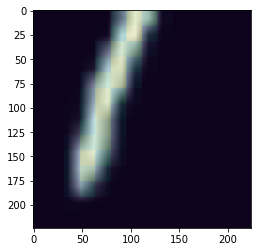

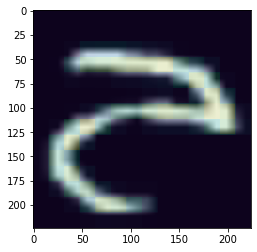

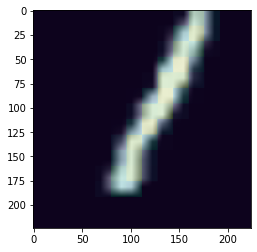

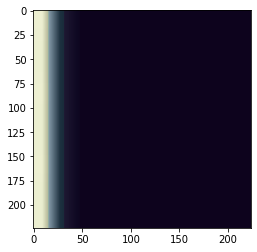

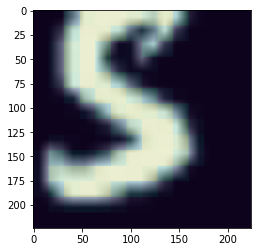

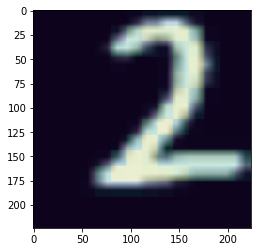

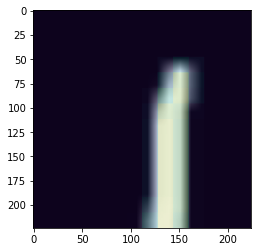

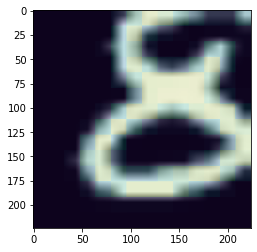

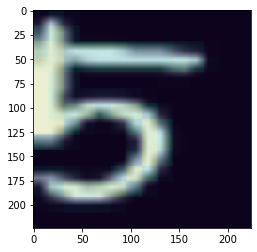

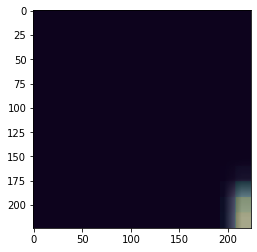

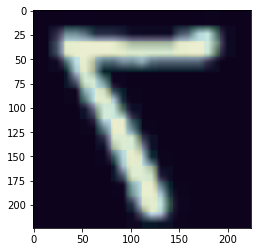

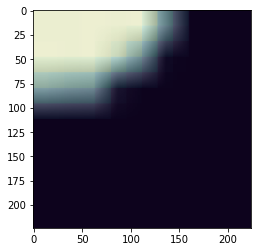

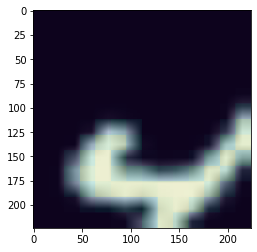

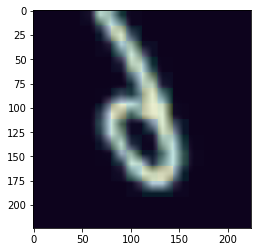

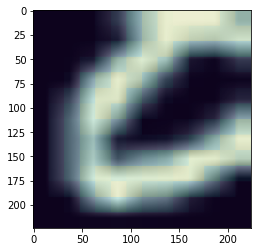

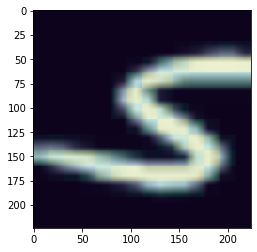

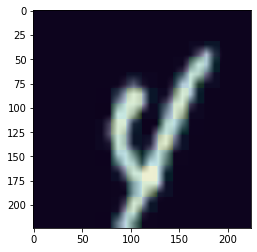

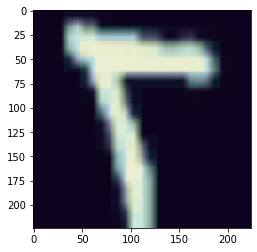

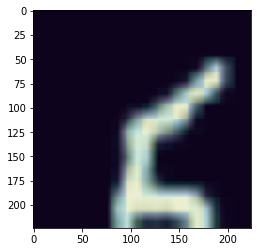

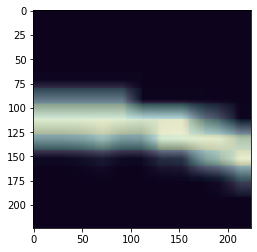

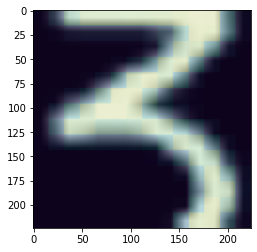

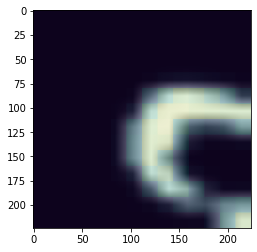

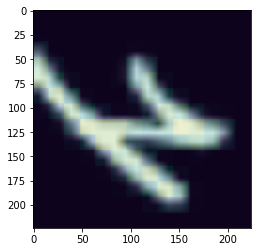

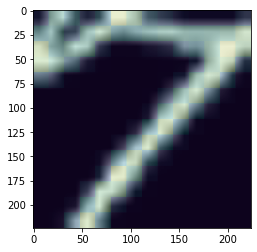

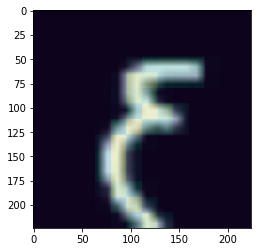

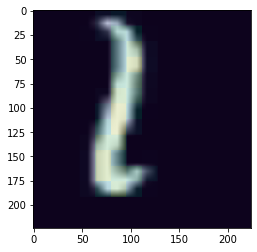

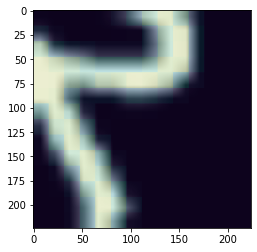

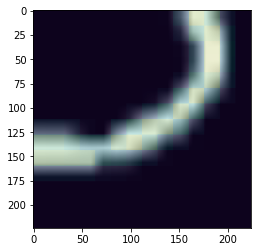

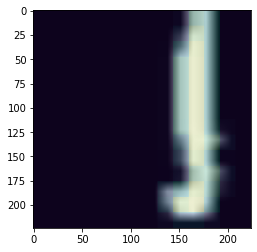

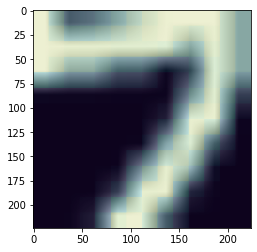

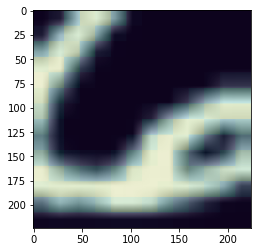

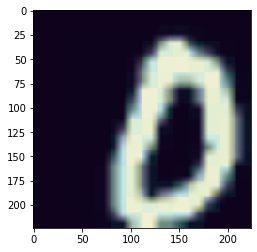

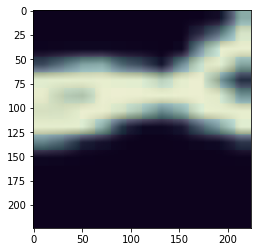

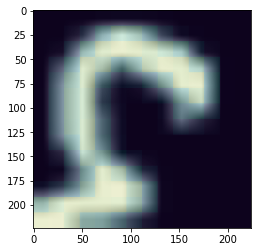

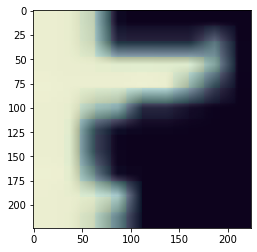

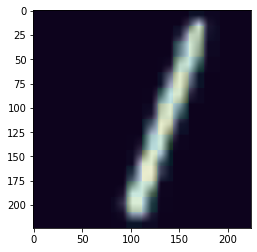

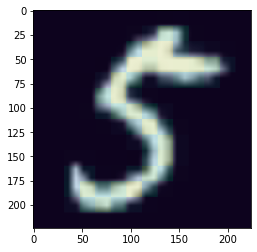

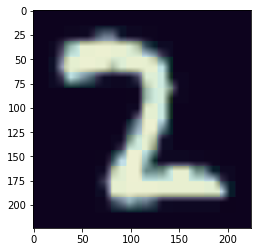

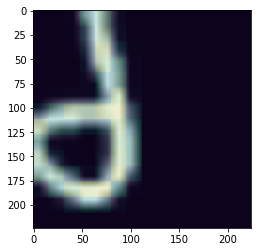

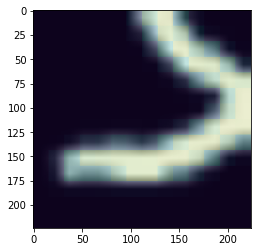

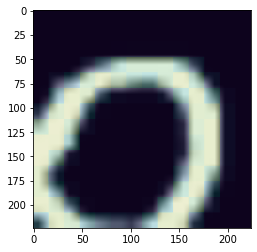

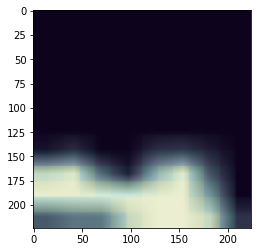

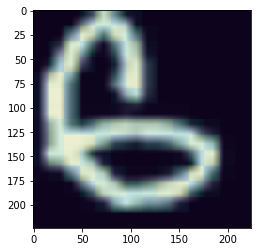

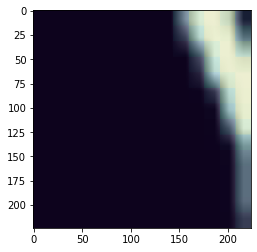

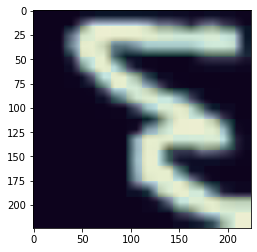

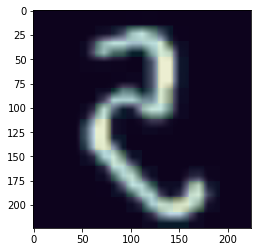

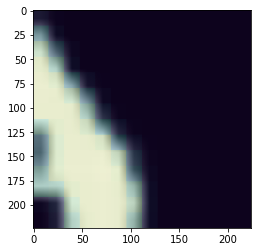

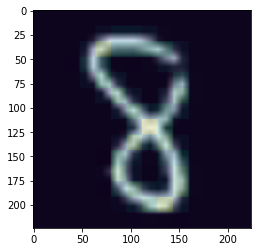

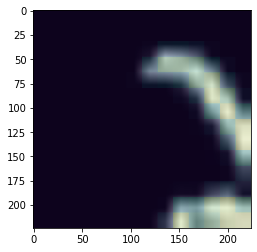

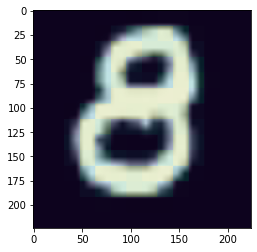

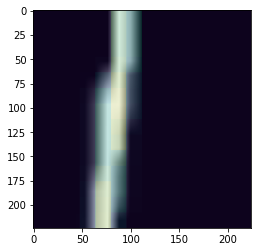

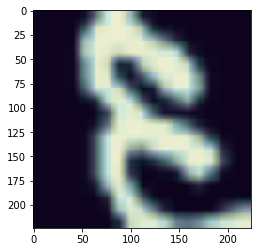

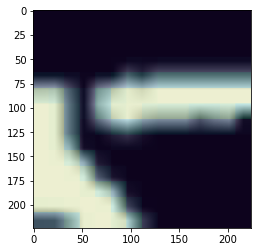

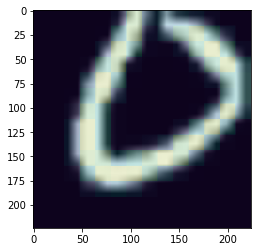

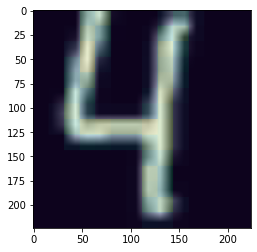

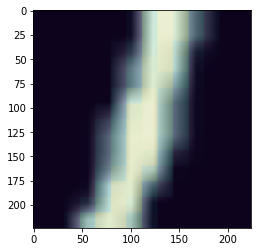

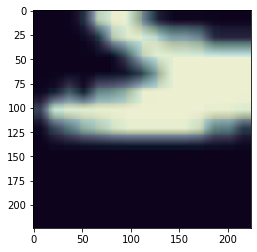

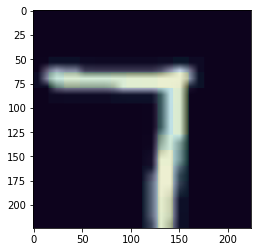

In [25]:
for idx in range(len(img)):
    
    attentinon = nnf.interpolate(feature[idx].unsqueeze(0).unsqueeze(0), size = size).squeeze().cpu().detach().numpy()
    plt.imshow(attentinon)
    plt.imshow(img[idx].cpu().permute(1,2,0), alpha = 0.8)
    plt.show()



In [18]:
feature = torch.mean(feature, dim = 1)
feature.shape

torch.Size([128, 14, 14])